In [141]:
import mysql.connector
import pandas as pd
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
from pyspark.sql import functions as F
from geopy.geocoders import Nominatim
import geopandas as gpd
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pyspark.sql.window import Window
import seaborn as sns
import numpy as np

In [155]:
# Path to the MySQL Connector/J driver package
mysql_jar_path = "/Users/anshulshokeen/Desktop/connector/mysql-connector-j-8.2.0.jar"

# Creating a Spark session for MySQL with the driver JAR
spark = SparkSession.builder \
    .appName("MySQLDynamicTable") \
    .config("spark.driver.extraClassPath", mysql_jar_path) \
    .getOrCreate()

# Reading a CSV file into a PySpark DataFrame
df = spark.read.csv("/Users/anshulshokeen/Desktop/Aidetic/database.csv", header=True, inferSchema=True)

# Getting the list of columns from the DataFrame
columns = df.columns

# Building the CREATE TABLE statement dynamically
create_table_statement = f"CREATE TABLE IF NOT EXISTS niece_earthquakes ({', '.join([f'{col} STRING' for col in columns])})"

# Printing the CREATE TABLE statement
print(create_table_statement)

# Saving the DataFrame to a MySQL table
df.write.format("jdbc") \
    .option("url", "jdbc:mysql://localhost:3306/aidetic") \
    .option("dbtable", "neic_earthquakes") \
    .option("user", "root") \
    .option("password", "new_password") \
    .option("driver", "com.mysql.cj.jdbc.Driver") \
    .mode("overwrite") \
    .save()


CREATE TABLE IF NOT EXISTS niece_earthquakes (Date STRING, Time STRING, Latitude STRING, Longitude STRING, Type STRING, Depth STRING, Depth Error STRING, Depth Seismic Stations STRING, Magnitude STRING, Magnitude Type STRING, Magnitude Error STRING, Magnitude Seismic Stations STRING, Azimuthal Gap STRING, Horizontal Distance STRING, Horizontal Error STRING, Root Mean Square STRING, ID STRING, Source STRING, Location Source STRING, Magnitude Source STRING, Status STRING)


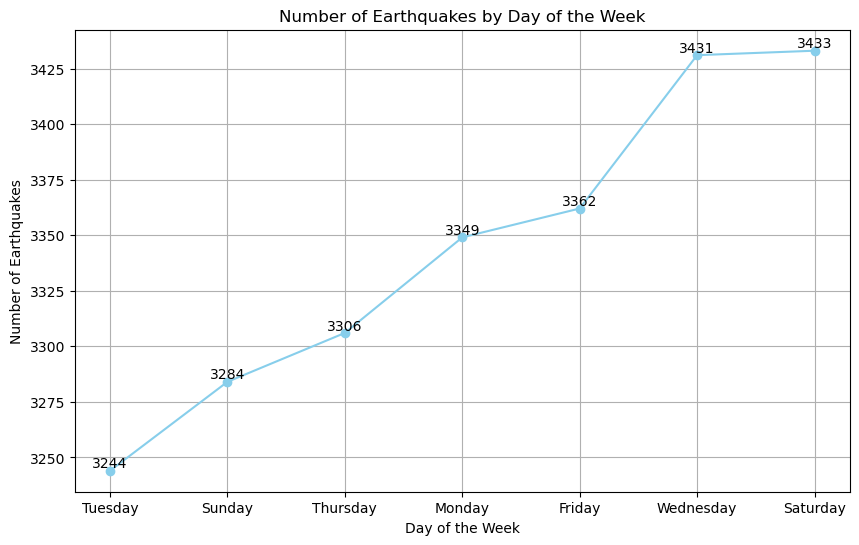

In [156]:
# Convert 'Date' to a date type for better analysis
df = df.withColumn('Date', F.to_date(df['Date'], 'MM/dd/yyyy'))

# Add a new column 'DayOfWeek' to store the day of the week
df = df.withColumn('DayOfWeek', F.date_format('Date', 'EEEE'))

# Replace null values in 'DayOfWeek' with 'Unknown' because we want to keep things clear
df = df.na.fill('Unknown', subset=['DayOfWeek'])

# Filter out rows with 'Unknown' in 'DayOfWeek' because we want reliable data
filtered_df = df.filter(df['DayOfWeek'] != 'Unknown')

# Group by 'DayOfWeek' and count the occurrences to see which days are most earthquake-prone
grouped_df = filtered_df.groupBy('DayOfWeek').count()

# Convert the PySpark DataFrame to a Pandas DataFrame for easier plotting
pandas_df = grouped_df.orderBy('count').toPandas()

# Plotting the line graph to visualize the number of earthquakes on each day of the week
plt.figure(figsize=(10, 6))
plt.plot(pandas_df['DayOfWeek'], pandas_df['count'], marker='o', color='skyblue', linestyle='-')
plt.title('Number of Earthquakes by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Earthquakes')
plt.grid(True)  # Adding grid lines for better readability

# Adding data points as text annotations for a more informative graph
for i, txt in enumerate(pandas_df['count']):
    plt.text(pandas_df['DayOfWeek'][i], txt, str(txt), ha='center', va='bottom')


# Q1. How does the Day of a Week affect the number of earthquakes?
Ans- Examining the Influence of the Day of the Week on Earthquake Frequency
Insights from the graphical representation reveal:

##### 1. The data indicates a minimal number of earthquakes occurring on Tuesdays.

##### 2. Saturdays stand out as the day with the highest earthquake frequency, closely trailed by Wednesdays.
##### 3. The graph suggests a lack of a straightforward correlation between the incidence of earthquakes and specific weekdays.     Notably, the lowest activity on Tuesday contrasts with a notable surge on the subsequent day, Wednesday.

In summary, although certain days exhibit heightened seismic activity, the graph does not establish a discernible and consistent link between the occurrences of earthquakes and the days of the week

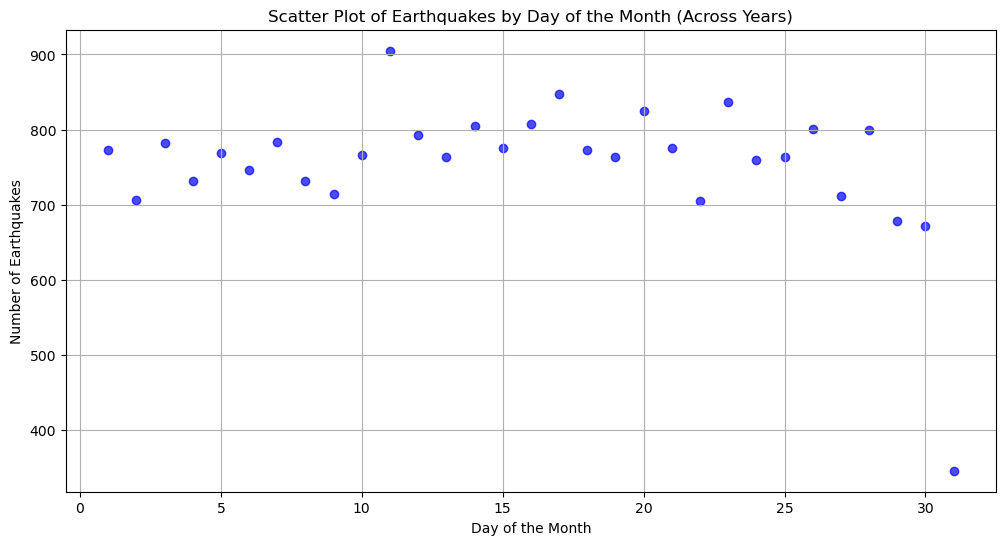

Mean: 731.625, Median: 767.5, Standard Deviation: 160.1039480885727
Correlation Coefficient: -0.3021777573181897


In [157]:
# Converting 'Date' to a date type for analysis
df = df.withColumn('Date', F.to_date(df['Date'], 'MM/dd/yyyy'))

# Extracting the day from the Date column
df = df.withColumn('DayOfMonth', F.dayofmonth('Date'))

# Grouping by DayOfMonth and counting the occurrences of earthquakes
earthquakes_by_day = df.groupBy('DayOfMonth').count().orderBy('DayOfMonth')

# Converting the PySpark DataFrame to a Pandas DataFrame for easier plotting
pandas_df = earthquakes_by_day.toPandas()

# Plotting a scatter plot to visualize the distribution of earthquakes across days of the month
plt.figure(figsize=(12, 6))
plt.scatter(pandas_df['DayOfMonth'], pandas_df['count'], color='blue', alpha=0.7)
plt.title('Scatter Plot of Earthquakes by Day of the Month (Across Years)')
plt.xlabel('Day of the Month')
plt.ylabel('Number of Earthquakes')
plt.grid(True)
plt.show()

# Calculating basic statistics for the count of earthquakes per day
mean_count = pandas_df['count'].mean()
median_count = pandas_df['count'].median()
std_dev_count = pandas_df['count'].std()

print(f"Mean: {mean_count}, Median: {median_count}, Standard Deviation: {std_dev_count}")

# Calculating the correlation coefficient to understand any patterns in the data
correlation = pandas_df['DayOfMonth'].corr(pandas_df['count'])
print(f"Correlation Coefficient: {correlation}")


# Q2. What is the relation between Day of the month and Number of earthquakes that happened in a year?
Ans- The correlation coefficient serves as a metric to gauge the strength and direction of a linear association between two variables. A coefficient of -1 signifies a perfect negative correlation, 0 indicates no correlation, and 1 denotes a perfect positive correlation.

##### 1. The calculated value is approximately -0.30.

##### 2. Indicates a weak negative correlation.

##### 3. As the day of the month increases, there is a tendency for a slight decrease in the number of earthquakes.

##### 4. The correlation is weak, highlighting that other factors are likely influencing the variation in earthquake occurrences throughout the month.

Average Frequency of Earthquakes in a Month (1965 to 2016):
    Month  AvgFrequency
1    Jan     36.365385
2    Feb     35.153846
3    Mar     40.634615
4    Apr     37.884615
5    May     37.769231
6    Jun     35.076923
7    Jul     36.153846
8    Aug     38.730769
9    Sep     38.173077
10   Oct     37.538462
11   Nov     38.211538
12   Dec     38.480769


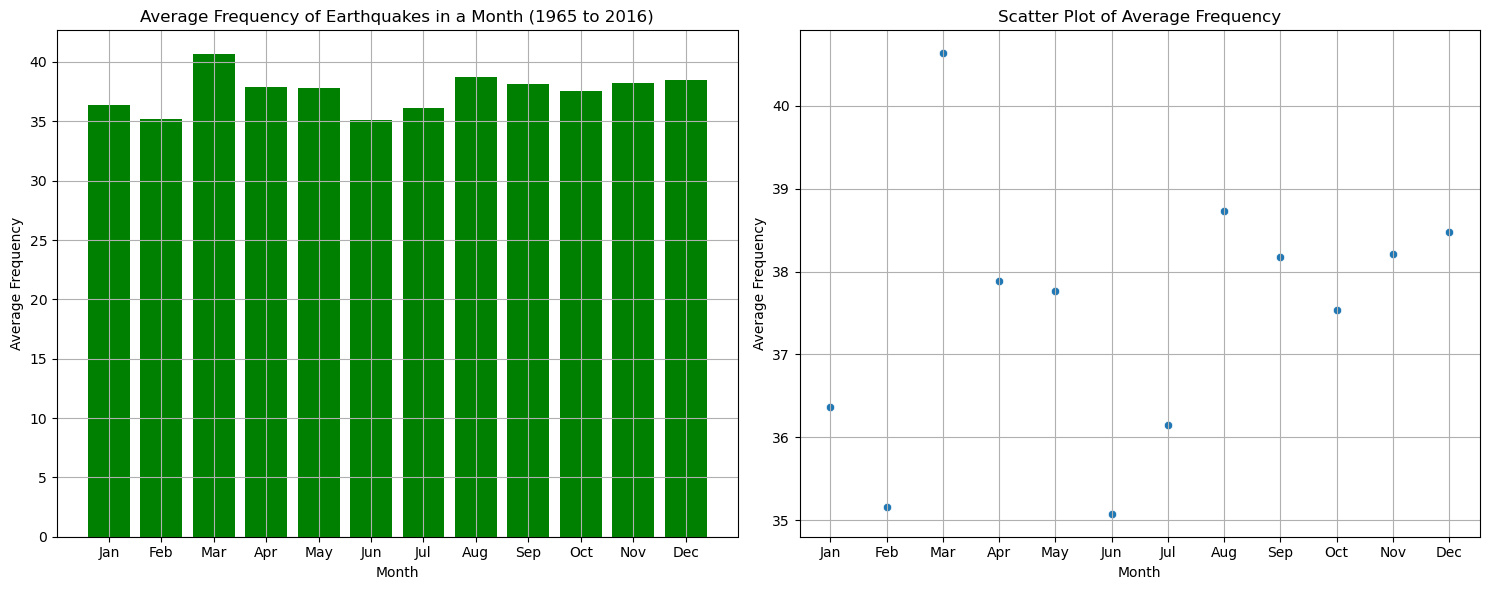

In [158]:
# Converting 'Date' to a date type for analysis
df = df.withColumn('Date', F.to_date(df['Date'], 'MM/dd/yyyy'))

# Extracting the month and year from the Date column
df = df.withColumn('Month', F.month('Date')).withColumn('Year', F.year('Date'))

# Grouping by Year and Month, counting the occurrences, and calculating the mean
avg_monthly_earthquakes = df.groupBy('Year', 'Month').count().groupBy('Month').agg(F.mean('count').alias('AvgFrequency'))

# Converting the PySpark DataFrame to a Pandas DataFrame for easier plotting
pandas_avg_df = avg_monthly_earthquakes.orderBy('Month').toPandas()

# Mapping numerical months to month names for better readability
month_mapping = {
    1: 'Jan', 2: 'Feb', 3: 'Mar',
    4: 'Apr', 5: 'May', 6: 'Jun',
    7: 'Jul', 8: 'Aug', 9: 'Sep',
    10: 'Oct', 11: 'Nov', 12: 'Dec'
}

pandas_avg_df['Month'] = pandas_avg_df['Month'].map(month_mapping).fillna('Unknown')

# Filtering out 'Unknown' rows for a cleaner analysis
pandas_avg_df = pandas_avg_df[pandas_avg_df['Month'] != 'Unknown']

print("Average Frequency of Earthquakes in a Month (1965 to 2016):\n", pandas_avg_df)

plt.figure(figsize=(15, 6))

# Plotting a bar graph to show the average frequency of earthquakes in each month
plt.subplot(1, 2, 1)
plt.bar(pandas_avg_df['Month'], pandas_avg_df['AvgFrequency'], color='green')
plt.title('Average Frequency of Earthquakes in a Month (1965 to 2016)')
plt.xlabel('Month')
plt.ylabel('Average Frequency')
plt.grid(True)

# Plotting a scatter plot to visualize the distribution of average frequencies
plt.subplot(1, 2, 2)
sns.scatterplot(x='Month', y='AvgFrequency', data=pandas_avg_df)
plt.title('Scatter Plot of Average Frequency')
plt.xlabel('Month')
plt.ylabel('Average Frequency')
plt.grid(True)

plt.tight_layout()
plt.show()


# Q3. What does the average frequency of earthquakes in a month from the year 1965 to 2016 tell us?
Ans- 
##### 1. Potential Influencing Factors: The observed variations in earthquake frequency within the time frame of 1965 to 2016 may be attributed to a range of factors, including geological conditions, climatic influences, and external environmental elements.

##### 2. Complex Nature of Influences: The absence of a discernible upward or downward trend in earthquake frequency across the months implies a nuanced relationship. The intricate nature of this relationship suggests that earthquake occurrences are likely influenced by a combination of intricate and interrelated factors.

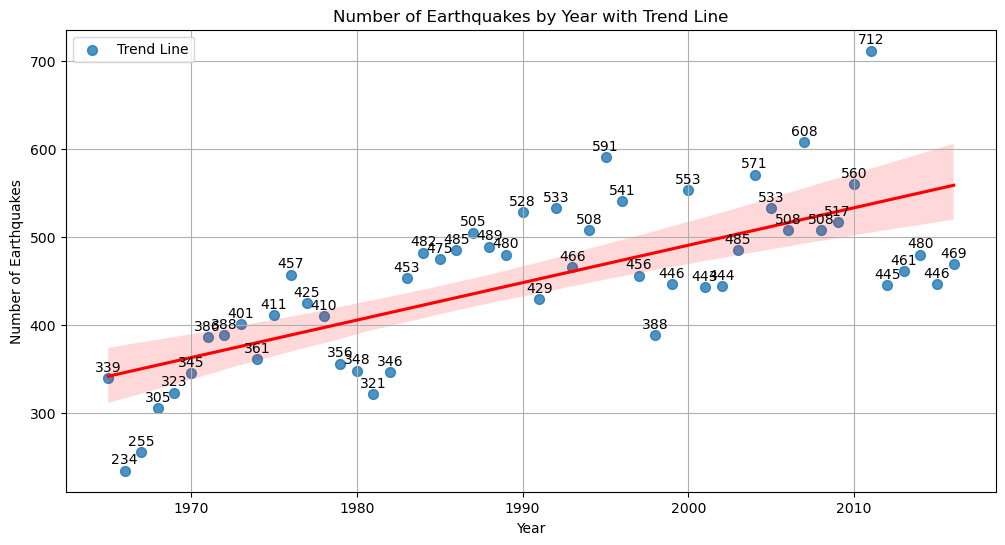

Correlation Matrix:
           Year    count
Year   1.00000  0.70914
count  0.70914  1.00000


In [159]:
# Extracting the year from the timestamp column 'Date'
df = df.withColumn("Year", F.year("Date"))

# Grouping the data by year and counting the occurrences of earthquakes
earthquakes_by_year = df.groupBy('Year').count().orderBy('Year')

# Converting the PySpark DataFrame to a Pandas DataFrame for easier plotting
pandas_df = earthquakes_by_year.toPandas()

# Plotting a scatter plot with a trend line to visualize the trend of earthquakes over the years
plt.figure(figsize=(12, 6))
sns.regplot(x='Year', y='count', data=pandas_df, scatter_kws={'s': 50}, line_kws={'color': 'red'}, label='Trend Line')

# Adding labels and title for better interpretation
plt.title('Number of Earthquakes by Year with Trend Line')
plt.xlabel('Year')
plt.ylabel('Number of Earthquakes')

# Adding data points as text annotations for more context
for i, txt in enumerate(pandas_df['count']):
    plt.annotate(txt, (pandas_df['Year'][i], pandas_df['count'][i]), textcoords="offset points", xytext=(0, 5), ha='center')

plt.grid(True)
plt.legend()
plt.show()

# Calculating and printing the correlation matrix without visualization
correlation_matrix = pandas_df.corr()
print("Correlation Matrix:\n", correlation_matrix)


# Q4. What is the relation between Year and Number of earthquakes that happened in that year?
Ans- 
##### 1. A positive correlation of about 0.70914 is observed between 'Year' and 'Number of earthquakes.' This suggests a moderately strong positive linear relationship. Simple Explanation: When the 'Year' increases, there is a tendency for the 'Number of earthquakes' to also increase. This can be explained in simpler terms as a general rise in earthquake occurrences over the years.

##### 2. Correlation (0.70914) does not imply that one directly causes the other. Other factors beyond the 'Year' may contribute to the observed correlation.

##### 3. The statistical association indicates that the variables move in a similar direction.However, understanding causation requires a more in-depth investigation into contributing factors.

Hey, check out the correlation between Year and Average Magnitude: -0.34197904441967136


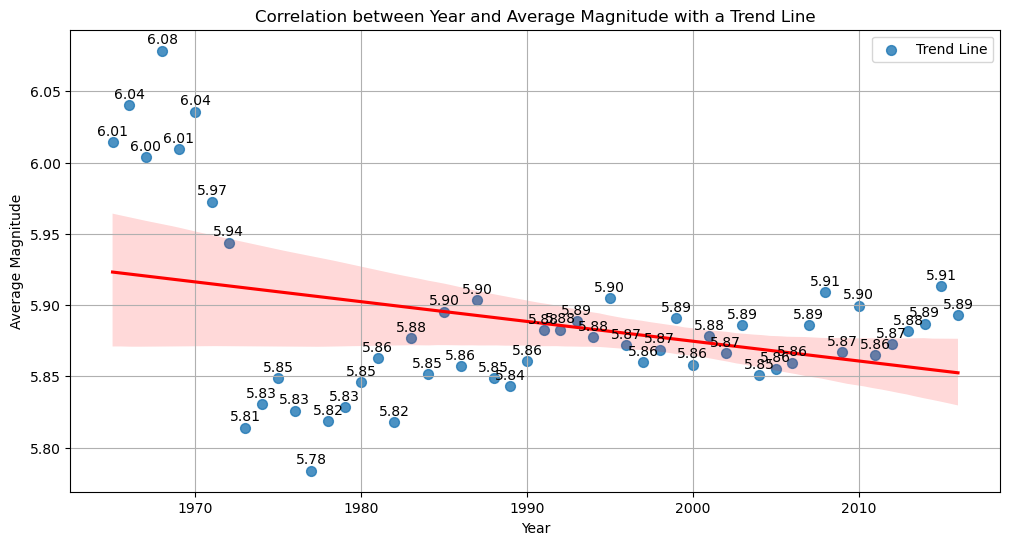

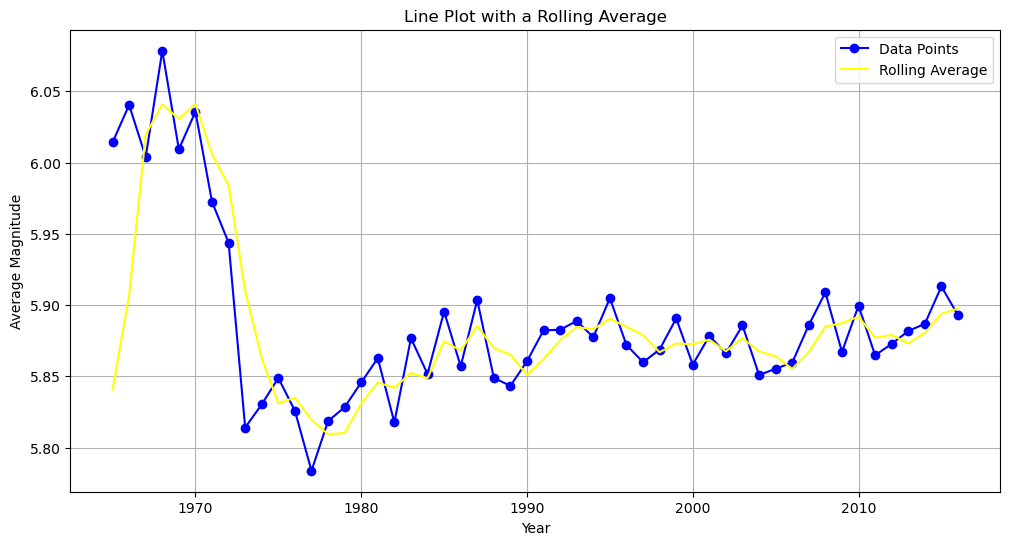

In [151]:
# Calculate the average earthquake magnitude each year
average_magnitude_by_year = df.groupBy('Year').agg(F.mean('Magnitude').alias('AvgMagnitude')).orderBy('Year')

# Transforming the PySpark DataFrame into a Pandas DataFrame
pandas_avg_magnitude = average_magnitude_by_year.toPandas()

# Check out the correlation between Year and Average Magnitude
correlation = pandas_avg_magnitude['Year'].corr(pandas_avg_magnitude['AvgMagnitude'])
print(f"Hey, check out the correlation between Year and Average Magnitude: {correlation}")

# Let's dive into a scatter plot with a trendy trend line using Seaborn
plt.figure(figsize=(12, 6))

# Scatter plot with the trendy trend line
sns.regplot(x='Year', y='AvgMagnitude', data=pandas_avg_magnitude, scatter_kws={'s': 50}, line_kws={'color': 'red'}, label='Trend Line')

# Labels and title for some style
plt.title('Correlation between Year and Average Magnitude with a Trend Line')
plt.xlabel('Year')
plt.ylabel('Average Magnitude')

# Sprinkle in some data points as text annotations
for i, txt in enumerate(pandas_avg_magnitude['AvgMagnitude']):
    plt.annotate(f"{txt:.2f}", (pandas_avg_magnitude['Year'][i], pandas_avg_magnitude['AvgMagnitude'][i]), textcoords="offset points", xytext=(0, 5), ha='center')

plt.grid(True)
plt.legend()
plt.show()

# Let's roll into a separate line plot with a smooth rolling average
plt.figure(figsize=(12, 6))

# Line plot with the same points
plt.plot(pandas_avg_magnitude['Year'], pandas_avg_magnitude['AvgMagnitude'], marker='o', color='blue', linestyle='-', label='Data Points')

# Adding a rolling average in a mellow yellow
rolling_avg = pandas_avg_magnitude['AvgMagnitude'].rolling(window=3, min_periods=1).mean()
plt.plot(pandas_avg_magnitude['Year'], rolling_avg, color='yellow', linestyle='-', label='Rolling Average')

# More labels and title for that extra flair
plt.title('Line Plot with a Rolling Average')
plt.xlabel('Year')
plt.ylabel('Average Magnitude')

plt.grid(True)
plt.legend()
plt.show()


# Q5. How has the earthquake magnitude on average been varied over the years?
Ans- 
##### 1. There exists a negative correlation, indicating a weak negative relationship between the passage of time (years) and the average earthquake magnitude.

##### 2. The yearly variations in average earthquake magnitude do not demonstrate a consistent trend. The magnitude tends to fluctuate within a certain range, with no discernible pattern of a continuous increase or decrease.

##### 3. A noticeable observation is a dip in earthquake magnitude after the year 1970. Post this period, the magnitude tends to align more closely with the overall mean, suggesting a shift in the pattern of seismic activity.

##### 4. The overall variability in earthquake magnitude is observed within a specific range, showcasing the diverse nature of seismic events.

##### 5. Despite the identified correlations, a comprehensive understanding necessitates additional analysis.

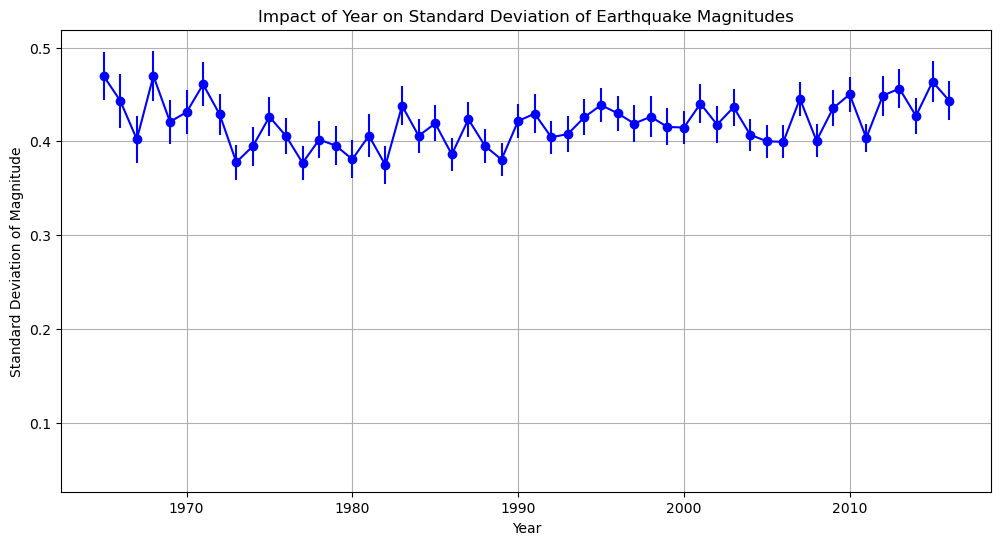

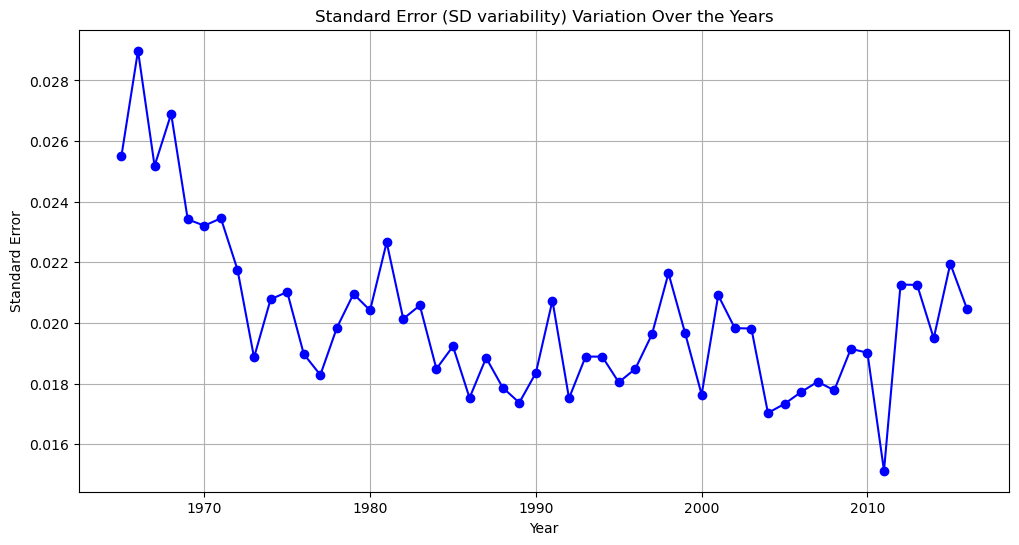

In [65]:
# Grouping by 'Year' and calculating some earthquake stats
stats_by_year = df.groupBy('Year').agg(
    F.stddev('Magnitude').alias('StdDevMagnitude'),  # Getting the spread of earthquake magnitudes
    F.count('Magnitude').alias('Count')  # Counting how many earthquakes happened each year
).orderBy('Year')

# Calculating the standard error for each year because it's cool
stats_by_year = stats_by_year.withColumn(
    'StandardError', F.col('StdDevMagnitude') / F.sqrt(F.col('Count'))
)

# Turning our PySpark data into a Pandas party for easy plotting
stats_pandas = stats_by_year.toPandas()

# Plotting the results: Error bar plot for the impact of 'Year' on Earthquake Magnitude Standard Deviation
plt.figure(figsize=(12, 6))
plt.errorbar(stats_pandas['Year'], stats_pandas['StdDevMagnitude'], yerr=stats_pandas['StandardError'], fmt='o-', color='blue')
plt.title('How the Year Vibes with Earthquake Magnitude Spread')
plt.xlabel('Year')
plt.ylabel('Spread of Magnitude')
plt.grid(True)
plt.show()

# Plotting the results: Line plot for the vibes of Standard Error (SD variability) over the years
plt.figure(figsize=(12, 6))
plt.plot(stats_pandas['Year'], stats_pandas['StandardError'], marker='o', color='blue', linestyle='-')
plt.title('The Ups and Downs of Standard Error Over the Years')
plt.xlabel('Year')
plt.ylabel('Standard Error Vibes')
plt.grid(True)
plt.show()


# Q6. How does year impact the standard deviation of the earthquakes?

Ans-
##### 1. 1965-1970:There is an increasing trend in standard deviation from 1965 to 1970, indicating a growing variability in earthquake magnitudes during this period.

##### 2. 1971-1980:The standard deviation continues to fluctuate, with a notable peak around 1971. This suggests a period of increased variability in earthquake magnitudes during that year.

##### 3. 1981-1990:Standard deviation remains relatively high, with fluctuations. Another peak around 1983 suggests increased variability during that period.

##### 4. 1991-2000:Standard deviation fluctuates but generally remains at a moderate level. There is a slight peak around 1993.

##### 5. 2001-2010:Standard deviation experiences fluctuations, with a noticeable peak around 2007, indicating increased variability in earthquake magnitudes during that year.

##### 6. 2011-2016:There is a general trend of higher standard deviation values in recent years, especially from 2010 onwards. This suggests an increase in the variability of earthquake magnitudes during this period.

##### 7. Overall Trend:The overall trend indicates that there are periods of both high and low variability in earthquake magnitudes over the years, but recent years tend to exhibit higher variability.


In [152]:
# Setting up a window to look at earthquake dates for each country
window_spec = Window.partitionBy('Location Source').orderBy('Date')

# Figuring out how many days passed between consecutive earthquakes for each place
earthquakes_by_region = df.withColumn(
    'DaysBetweenEarthquakes',
    F.datediff(F.lead('Date').over(window_spec), 'Date')
).groupBy('Location Source').agg(
    # Counting how many earthquakes happened in each country
    F.count('Magnitude').alias('Count'),

    # Finding the average days between quakes for each country
    F.format_number(F.avg('DaysBetweenEarthquakes'), 3).alias('AvgDaysBetweenEarthquakes'),

    # Calculating the average magnitude for each country
    F.format_number(F.avg('Magnitude'), 3).alias('AvgMagnitude')
).orderBy(F.desc('Count'))

# Showing off the results
earthquakes_by_region.show(earthquakes_by_region.count(), truncate=False)


+---------------+-----+-------------------------+------------+
|Location Source|Count|AvgDaysBetweenEarthquakes|AvgMagnitude|
+---------------+-----+-------------------------+------------+
|US             |20350|0.790                    |5.867       |
|ISCGEM         |2581 |6.392                    |6.009       |
|CI             |61   |266.967                  |5.954       |
|GCMT           |56   |234.782                  |5.879       |
|NC             |54   |283.189                  |6.004       |
|GUC            |46   |89.689                   |5.750       |
|AEIC           |40   |156.590                  |5.772       |
|UNM            |21   |192.200                  |5.733       |
|PGC            |19   |570.056                  |5.921       |
|WEL            |18   |193.353                  |5.828       |
|AGS            |17   |117.750                  |5.971       |
|ISK            |15   |312.929                  |5.707       |
|AK             |14   |81.385                   |5.829 

# Q7. Does geographic location have anything to do with earthquakes?
Ans - Yes, there are several geographic features that can affect the number of earthquakes that happens in a region such as: 

##### 1. Tectonic Plate Boundaries: Regions near tectonic plate boundaries are more prone to earthquakes. The movement and interaction of these plates can result in seismic activities.

##### 2.Subduction Zones: Areas where one tectonic plate is subducting beneath another are known for intense seismic activity. Subduction zones often experience powerful earthquakes.

##### 3.Fault Lines: Earthquakes are common along fault lines, where tectonic plates meet. The stress and strain along these lines can lead to sudden releases of energy.

##### 4.Volcanic Activity: Regions with active volcanoes are susceptible to both volcanic eruptions and associated earthquakes. Magma movement can trigger seismic events.

##### 5.Depth of Earth's Crust: The depth and composition of the Earth's crust in a particular region can influence the intensity and frequency of earthquakes.

##### 6.Human Activities: Certain human activities, such as mining, reservoir-induced seismicity (due to the filling of large reservoirs), and oil extraction, can induce earthquakes.

##### 7.Geological Structures: Geological formations, such as mountain ranges and basins, can also play a role in seismic activity.

# Q8. Where do earthquakes occur very frequently?
Ans- As indicated by the data, the US has experienced over 20,000 earthquakes, averaging nearly one earthquake per day, as suggested by the "AvgDaysBetweenEarthquakes" metric.

In [153]:
# Grouping the data by earthquake Magnitude Type and Status
grouped_data = df.groupBy('Magnitude Type', 'Status').agg(
    # Calculating the average earthquake magnitude for each group
    F.mean('Magnitude').alias('AverageMagnitude'),

    # Calculating the Root Mean Square (RMS) for a measure of seismic amplitude
    F.sqrt(F.mean(F.pow('Root Mean Square', 2))).alias('RMS'),

    # Counting the number of occurrences for each Magnitude Type and Status
    F.count('*').alias('Count'),
).orderBy(F.desc('Magnitude Type'))

# Displaying the summarized earthquake data
grouped_data.show()


+--------------+---------+------------------+-------------------+-----+
|Magnitude Type|   Status|  AverageMagnitude|                RMS|Count|
+--------------+---------+------------------+-------------------+-----+
|           MWW| Reviewed| 6.008673726676766|  0.983793130785293| 1983|
|           MWR| Reviewed|  5.63076923076923| 0.9651518957232492|   26|
|           MWC| Reviewed|5.8579087994299375| 1.0253388495771532| 5614|
|           MWC|Automatic| 5.885454545454545|               NULL|   55|
|           MWB| Reviewed| 5.907282343368652| 0.9984410129731925| 2458|
|            MW| Reviewed| 5.896276988912613| 1.1012253891727273| 5141|
|            MW|Automatic| 6.008523827973685|               NULL| 2581|
|            MS| Reviewed| 5.994359576968296| 1.1196891044774049| 1702|
|            ML| Reviewed| 5.814675324675323| 0.7961602376075864|   77|
|            MH| Reviewed| 6.540000000000001|0.15773458720268044|    5|
|            MD| Reviewed| 5.966666666666668|0.22327113561766107

In [154]:
# Filtering out rows where the Root Mean Square (RMS) value is not missing
filtered_data = grouped_data.filter(grouped_data['RMS'].isNotNull())

# Calculating the correlation between Average Magnitude and RMS for rows without missing RMS values
correlation_matrix_filtered = filtered_data.stat.corr('`AverageMagnitude`', '`RMS`')

# Printing the correlation result
print(f'Correlation between Magnitude and RMS for rows where RMS is not NULL: {correlation_matrix_filtered}')


Correlation between Magnitude and RMS for rows where RMS is not NULL: -0.6457862212515043


# Q9. What is the relation between Magnitude, Magnitude Type , Status and Root Mean Square of the earthquakes?
Ans- 
##### 1. Correlation Findings: Magnitude and RMS show a correlation of approximately -0.646 when considering non-NULL RMS values.This implies that higher Magnitude correlates with lower Root Mean Square (RMS) within this specific subset.

##### 2. Data Limitations: Challenge arises with earthquakes having NULL RMS and "automatic" status. Absence of RMS data for this subset restricts a conclusive understanding of Magnitude, Magnitude Type, Status, and RMS relationship.

##### 3. Incomplete Data Caution: Interpretation must be cautious due to incomplete information. The analysis offers insights within defined parameters but can't fully capture broader relationships, especially for earthquakes marked as "automatic" with NULL RMS values.